In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets,layers,optimizers

In [57]:
import matplotlib
from matplotlib import pyplot as plt
#default parameters for plots
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['figure.titlesize'] = 20
matplotlib.rcParams['figure.figsize'] = [9, 7]
#matplotlib.rcParams['font.family'] = ['STKaiTi']
matplotlib.rcParams['axes.unicode_minus']=False 

In [6]:
import os

In [7]:
#自定义预处理函数
def preprocess(x,y):
    print(x.shape,y.shape)
    x = tf.cast(x, dtype = tf.float32) / 255.
    x = tf.reshape(x, [-1,28*28])#打平
    y = tf.cast(y, dtype = tf.int32)
    y = tf.one_hot(y, depth=10)
    return x,y

In [8]:
#加载minist 数据集
(x,y),(x_test,y_test) = datasets.mnist.load_data()
print('x:',x.shape,'y:',y.shape,'x test:',x_test.shape,'y test:',y_test)

x: (60000, 28, 28) y: (60000,) x test: (10000, 28, 28) y test: [7 2 1 ... 4 5 6]


In [9]:
#训练集
#构建Dataset对象，将数据转换成Dataset 对象后，一般需要再添加一系列的数据集标准处理步骤，如随机打散，预处理，按批装载等
batchsz = 512
train_db = tf.data.Dataset.from_tensor_slices((x,y))
train_db = train_db.shuffle(10000)#随机打散样本，不会打乱样本与标签映射关系
train_db = train_db.batch(batchsz)#512 one batch
train_db = train_db.map(preprocess)
train_db = train_db.repeat(20)

(None, 28, 28) (None,)


In [10]:
#测试集
test_db = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_db = test_db.shuffle(1000).batch(batchsz).map(preprocess)
x,y = next(iter(train_db))#从训练集中采样一个样本并观察 一个样本中有512组数据 784 = 28*28 打平后的结果
print('train sample:', x.shape, y.shape)#（512 是使用one-hot做了预处理）

(None, 28, 28) (None,)
train sample: (512, 784) (512, 10)


In [11]:
print(x[0], y[0])

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

In [61]:
def main():
    lr = 1e-2
    accs,losses=[],[]
    # 784 => 512
    w1, b1 = tf.Variable(tf.random.normal([784, 256], stddev=0.1)), tf.Variable(tf.zeros([256]))
    # 512 => 256
    w2, b2 = tf.Variable(tf.random.normal([256, 128], stddev=0.1)), tf.Variable(tf.zeros([128]))
    # 256 => 10
    w3, b3 = tf.Variable(tf.random.normal([128, 10], stddev=0.1)), tf.Variable(tf.zeros([10]))
    
    for step,(x,y) in enumerate(train_db):
        x = tf.reshape(x,(-1,784))
        
        with tf.GradientTape() as tape:
            
            h1 = x @ w1 + b1
            h1 = tf.nn.relu(h1)
            
            h2 = h1 @ w2 + b2
            h2 = tf.nn.relu(h2)
            
            out = h2 @ w3 + b3
            
            #compute loss
            loss = tf.square(y-out)
            loss = tf.reduce_mean(loss)
         
            
        # derivation
        grads = tape.gradient(loss, [w1, b1, w2, b2, w3, b3]) 
        for p, g in zip([w1, b1, w2, b2, w3, b3], grads):
            p.assign_sub(lr * g)#update parameter
            
        if step % 80 == 0:
            print(step,'loss:',float(loss))
            losses.append(float(loss))
        
        if step % 80 == 0:
            total,total_correct = 0. , 0
            
            for x, y in test_db:
                # layer1.
                h1 = x @ w1 + b1
                h1 = tf.nn.relu(h1)
                # layer2
                h2 = h1 @ w2 + b2
                h2 = tf.nn.relu(h2)
                # output
                out = h2 @ w3 + b3
                # [b, 10] => [b]
                pred = tf.argmax(out, axis=1)
                # convert one_hot y to number y
                y = tf.argmax(y, axis=1)
                # bool type
                correct = tf.equal(pred, y)
                # bool tensor => int tensor => numpy
                total_correct += tf.reduce_sum(tf.cast(correct, dtype=tf.int32)).numpy()
                total += x.shape[0]
            print(step, 'Evaluate Acc:', total_correct/total)

            accs.append(total_correct/total)
    plt.figure()
    x = [i*80 for i in range(len(losses))]
    plt.plot(x, losses, color='C0', marker='s', label='Train')
    plt.ylabel('MSE')
    plt.xlabel('Step')
    plt.legend()
    plt.savefig('train.svg')

    plt.figure()
    plt.plot(x, accs, color='C1', marker='s', label='Test')
    plt.ylabel('Accuracy')
    plt.xlabel('Step')
    plt.legend()
    plt.savefig('test.svg')
    
    

0 loss: 0.5749980807304382
0 Evaluate Acc: 0.109
80 loss: 0.18507882952690125
80 Evaluate Acc: 0.2177
160 loss: 0.14840109646320343
160 Evaluate Acc: 0.3175
240 loss: 0.1194458156824112
240 Evaluate Acc: 0.3951
320 loss: 0.11540504544973373
320 Evaluate Acc: 0.4524
400 loss: 0.10300364345312119
400 Evaluate Acc: 0.4958
480 loss: 0.09229107201099396
480 Evaluate Acc: 0.5286
560 loss: 0.0948304757475853
560 Evaluate Acc: 0.5546
640 loss: 0.08960755914449692
640 Evaluate Acc: 0.5767
720 loss: 0.08070846647024155
720 Evaluate Acc: 0.593
800 loss: 0.08015891164541245
800 Evaluate Acc: 0.6112
880 loss: 0.07828794419765472
880 Evaluate Acc: 0.6231
960 loss: 0.07617965340614319
960 Evaluate Acc: 0.6365
1040 loss: 0.0705631822347641
1040 Evaluate Acc: 0.6496
1120 loss: 0.07409576326608658
1120 Evaluate Acc: 0.6593
1200 loss: 0.07043208926916122
1200 Evaluate Acc: 0.6689
1280 loss: 0.06825431436300278
1280 Evaluate Acc: 0.6778
1360 loss: 0.06802282482385635
1360 Evaluate Acc: 0.6859
1440 loss: 0

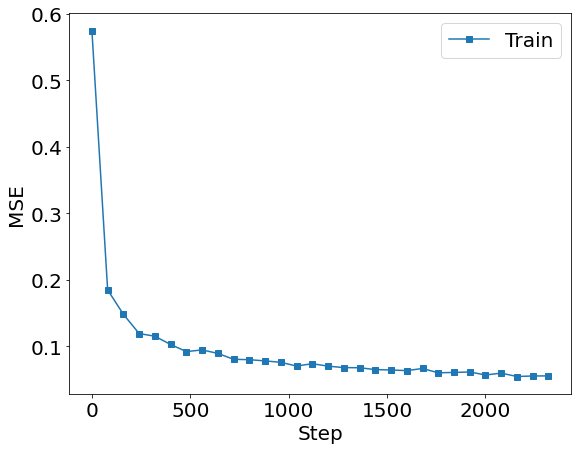

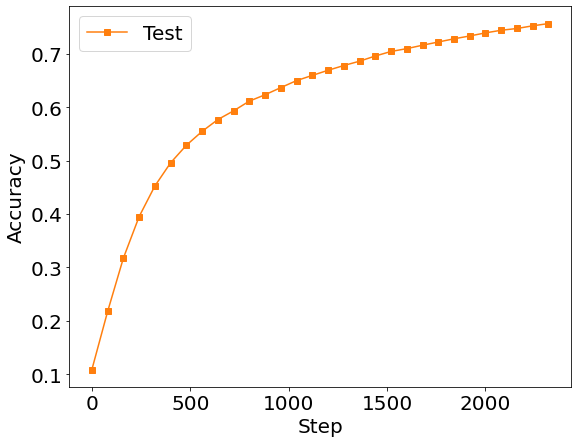

In [62]:
if __name__ == '__main__':
    main()